1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-
y分量形状 (200, 200)
u分量形状 (100, 100)
v分量形状 (100, 100)


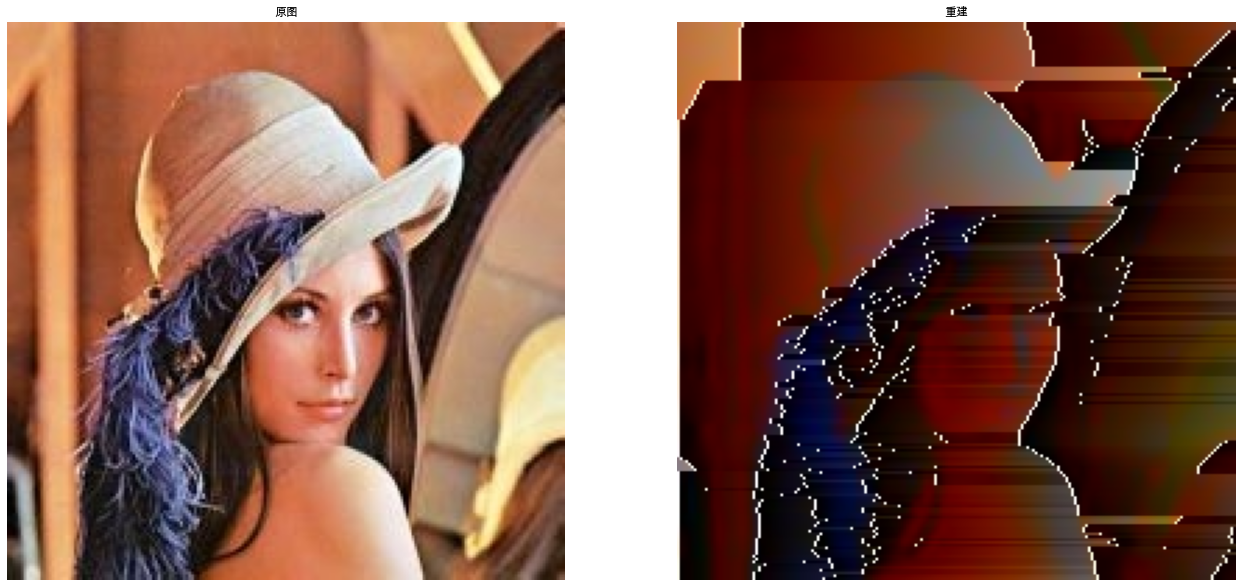

In [4]:
import cv2
import numpy as np
import io
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
fonts = FontProperties(fname = "/Library/Fonts/Arial Unicode.ttf")
plt.rcParams["font.family"] = 'Arial Unicode MS'
plt.rcParams['axes.unicode_minus']=False


# 读取图片，并转换为 y,v, u 分量。
img = cv2.imread('img/lena.jpg')
h, w = img.shape[:2]  # 高，宽

# 将 BGR 转换为 YCrCb（YCrCb 应用 YCrCb JPEG（或 YCC），“全范围”，
# 其中 Y 范围为 [0, 255]，U、V 范围为 [0, 255]（这是默认的 JPEG 格式颜色空间格式）。

yvu = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
y, v, u = cv2.split(yvu)

# 下采样 U 和 V（应用 420 格式）。
u = cv2.resize(u, (u.shape[1] // 2, u.shape[0] // 2))  # 要注意 w或h 为单数的情况
v = cv2.resize(v, (v.shape[1] // 2, v.shape[0] // 2))
print('1-'*50)
print('y分量形状',y.shape)
print('u分量形状',u.shape)
print('v分量形状',v.shape)
# 打开内存中的字节流（而不是使用 文件）
# 将 Y、U 和 V 写入“流”。之后就可以以字节的形式读取，
# 这个是为了模拟读取YUV文件的情况，直接由上面的yuv分量转换形状为一维数据应该也可以
# 这样做的原因是我在网上找的DPCM的C语言版本都是直接读取 .yuv文件的，我为了遵循他们，就这么处理了（其实是懒。。）

f = io.BytesIO()

f.write(y.tobytes())
f.write(u.tobytes())
f.write(v.tobytes())
f.seek(0)

img_np = np.frombuffer(f.read(), np.uint8)  # 原图的yuv420,一定要420,要不然要修改数组截取大小

img_yuv_len = img_np.size
img_y_len = h * w

y = img_np[:img_y_len]
u = img_np[img_y_len:(img_yuv_len - img_y_len) // 2 + img_y_len]  # 要注意 w或h 为单数的情况
v = img_np[(img_yuv_len - img_y_len) // 2 + img_y_len:]

# DPCM量化编码，采用边编码，边解码的形式，核心是下面for循环部分
img_re = np.zeros(img_y_len, np.uint16)  # 用来存储重建图像,因为中间计算可能超过255，先用16，后面转回8
yprebuff = np.zeros(img_y_len, np.uint16)  # 预测

radio=512/(1<<1)  # //量化因子  8是左向预测8bit量化，如果要进行4或2等的自行更改
for i in range(h):
    for j in range(w):
        # 左向预测8bit量化
        if j == 0:
            # 每行第一个像素要进行特殊处理，或保留，或进行一定预测，本设计中是做一定变换预测
            ypre = y[j + i * w]-128  # 计算预测误差
            yprebuff[j + i * w] = (ypre+255)/radio  # 量化预测误差
            img_re[j + i * w] = (yprebuff[j + i * w]-255/radio)*radio+128  # 重建像素,j解码
            if img_re[j + i * w]>255:
                img_re[j + i * w] = 255# 防止重建像素超过255
            yprebuff[j + i * w] = yprebuff[j + i * w]*radio/2

        else:
            ypre = y[j + i * w] - img_re[j + i * w - 1]  # 计算预测误差
            yprebuff[j + i * w] = (ypre+255) /radio  # 量化  # 量化器
            img_re[j + i * w] = (yprebuff[j + i * w]-255/radio)*radio+img_re[j + i * w - 1]  # 反量化
            yprebuff[j + i * w] = yprebuff[j + i * w] * radio / 2  # 预测器
            if img_re[j + i * w]>255:
                img_re[j + i * w] = 255# 防止重建电平超过255
img_re = img_re.astype(np.uint8) # 用来存储重建图像,后面转回uint8
yprebuff = yprebuff.astype(np.uint8)  # 预测误差

##########################################################################################
# 重建图片
y = y.reshape((h,w))  # 转换向量形状回原来的y分量

yprebuff = yprebuff.reshape((h,w))  # 预测的y分量

img_re = img_re.reshape((h,w))  # 重建的y分量

u = u.reshape((h//2,w//2))  # 恢复采样后的u分量
v = v.reshape((h//2,w//2))
ru = cv2.resize(u,(w,h))  # 恢复采样前的u分量，用这个u分量来重建图片文件
rv = cv2.resize(v,(w,h))

yvu = cv2.merge((y, rv, ru))
bgr = cv2.cvtColor(yvu, cv2.COLOR_YCrCb2BGR)  # 将原来的y,u,v分量转换回图片

yvu_pre = cv2.merge((yprebuff, rv, ru))
bgr_pre = cv2.cvtColor(yvu_pre, cv2.COLOR_YCrCb2BGR)  # 将y的预测误差转换为图片

yvu_re = cv2.merge((img_re, rv, ru))
bgr_re = cv2.cvtColor(yvu_re, cv2.COLOR_YCrCb2BGR)  # 将解码后的的y,u,v分量转换回原图
plt.figure(figsize=(22, 11))
plt.subplot(121), plt.imshow(cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)),
plt.title('原图'), plt.axis('off')
# plt.subplot(132), plt.imshow(cv2.cvtColor(bgr_pre, cv2.COLOR_BGR2RGB), cmap='gray'),
# plt.title('预测误差'), plt.axis('off')
plt.subplot(122), plt.imshow(cv2.cvtColor(bgr_re, cv2.COLOR_BGR2RGB), cmap='gray'),
plt.title('重建'), plt.axis('off')
plt.show()